In [1]:
import numpy as np
import pandas as pd
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Exploratory Data Analysis & Setup:

In [7]:
img_size = 224 #VGG model only accepts 224x224
img_dir = 'odr_dataset/preprocessed_images'
df = pd.read_csv('odr_dataset/full_df.csv')
df.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [8]:
# show glaucoma data
df[df.G==1].head(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
34,43,35,Male,43_left.jpg,43_right.jpg,wet age-related macular degeneration,dry age-related macular degeneration，glaucoma,0,0,1,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",43_right.jpg
78,95,46,Male,95_left.jpg,95_right.jpg,suspected glaucoma,hypertensive retinopathy,0,0,1,0,0,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['H'],"[0, 0, 0, 0, 0, 1, 0, 0]",95_right.jpg
129,153,79,Male,153_left.jpg,153_right.jpg,glaucoma,dry age-related macular degeneration,0,0,1,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",153_right.jpg
141,167,71,Male,167_left.jpg,167_right.jpg,glaucoma,glaucoma,0,0,1,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['G'],"[0, 0, 1, 0, 0, 0, 0, 0]",167_right.jpg
150,178,54,Male,178_left.jpg,178_right.jpg,dry age-related macular degeneration，glaucoma,dry age-related macular degeneration,0,0,1,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",178_right.jpg
205,238,70,Male,238_left.jpg,238_right.jpg,dry age-related macular degeneration,dry age-related macular degeneration，glaucoma,0,0,1,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",238_right.jpg
212,247,49,Male,247_left.jpg,247_right.jpg,dry age-related macular degeneration，glaucoma,dry age-related macular degeneration，glaucoma,0,0,1,0,1,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",247_right.jpg
319,365,60,Female,365_left.jpg,365_right.jpg,hypertensive retinopathy，suspected glaucoma,hypertensive retinopathy，suspected glaucoma,0,0,1,0,0,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['H'],"[0, 0, 0, 0, 0, 1, 0, 0]",365_right.jpg
510,583,54,Male,583_left.jpg,583_right.jpg,glaucoma,glaucoma,0,0,1,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['G'],"[0, 0, 1, 0, 0, 0, 0, 0]",583_right.jpg
546,625,72,Female,625_left.jpg,625_right.jpg,cataract，suspected glaucoma,cataract，branch retinal vein occlusion,0,0,1,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",625_right.jpg


In [9]:
# modify DF to focus on diagnostic terms
df = df.iloc[:, 1:7]
df.head(5)

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [10]:
# separate glaucoma into its own DF
df_l_glaucoma = df[df['Left-Diagnostic Keywords'].str.match('glaucoma')]
df_r_glaucoma = df[df['Right-Diagnostic Keywords'].str.match('glaucoma')]
df_glaucoma = df_l_glaucoma['Left-Fundus'].append(df_r_glaucoma['Right-Fundus'], ignore_index=True)

df_glaucoma.head(5)

0     153_left.jpg
1     167_left.jpg
2     583_left.jpg
3    1209_left.jpg
4    1210_left.jpg
dtype: object

In [11]:
len(df_glaucoma)

494

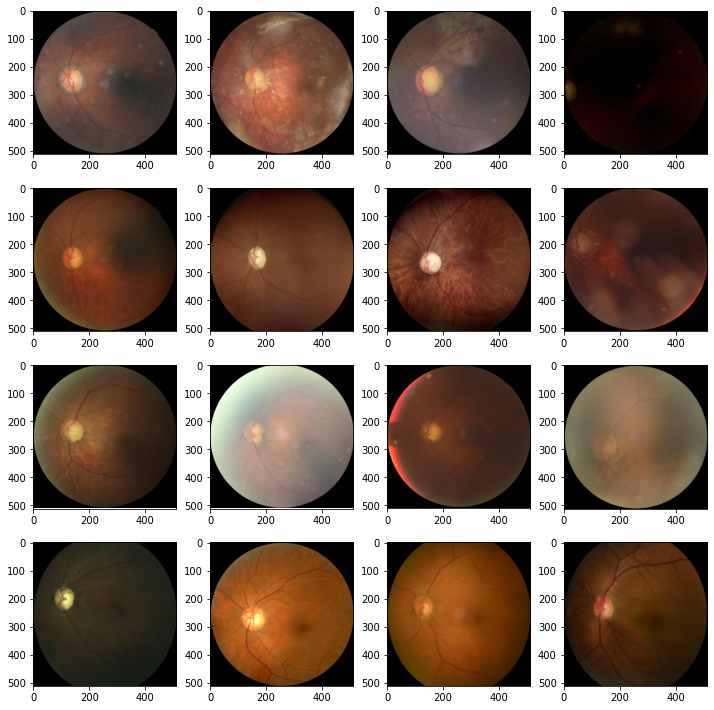

In [14]:
# example grid of glaucoma fundus images
plt.figure(figsize=(10,10))
for i in range(16):
    img = cv2.cvtColor(cv2.imread(os.path.join(img_dir, df_glaucoma[i])), cv2.COLOR_BGR2RGB)
    plt.subplot(4,4,i+1)
    plt.imshow(img)

plt.tight_layout()

In [20]:
# separate out a normal DF
df_l_normal = df[df['Left-Diagnostic Keywords'].str.match('normal')]
df_r_normal = df[df['Right-Diagnostic Keywords'].str.match('normal')]
df_normal = df_l_normal['Left-Fundus'].append(df_r_normal['Right-Fundus'], ignore_index=True)

df_normal.head(5)

0     1_left.jpg
1     8_left.jpg
2     9_left.jpg
3    14_left.jpg
4    15_left.jpg
dtype: object

In [21]:
# select random set from normal equal to glaucoma dataset size
df_norm_random = df_normal.sample(n=len(df_glaucoma))
df_norm_random.head(3)

4516    2342_right.jpg
3262    2458_right.jpg
24         97_left.jpg
dtype: object

In [17]:
# reset index
df_norm_random.reset_index(drop=True)

0       1210_left.jpg
1      1258_right.jpg
2      1388_right.jpg
3       1411_left.jpg
4       1479_left.jpg
            ...      
489     1327_left.jpg
490     1334_left.jpg
491    1488_right.jpg
492    1267_right.jpg
493    1443_right.jpg
Length: 494, dtype: object

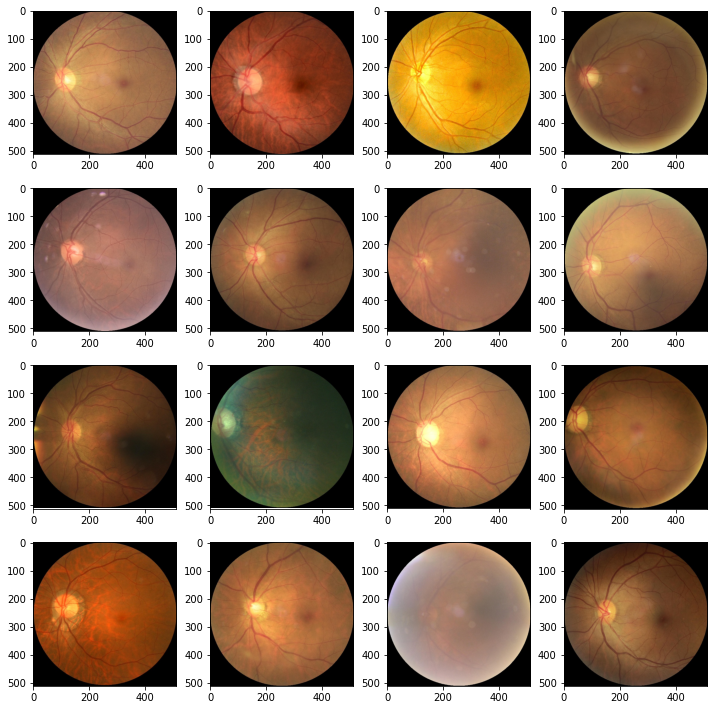

In [22]:
# example grid of normal fundus images
plt.figure(figsize=(10,10))
for i in range(16):
    img2 = cv2.cvtColor(cv2.imread(os.path.join(img_dir, df_normal[i])), cv2.COLOR_BGR2RGB)
    plt.subplot(4,4,i+1)
    plt.imshow(img2)

plt.tight_layout()

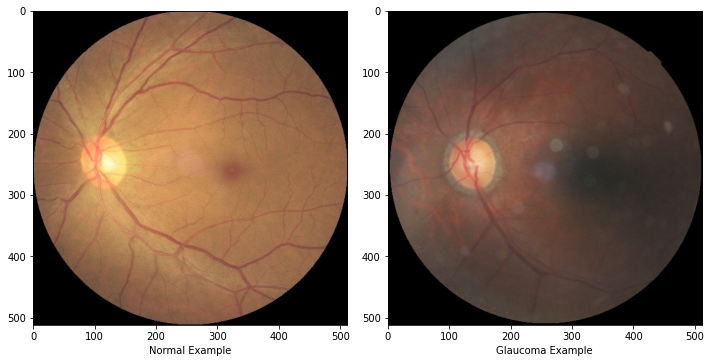

In [24]:
# normal vs. glaucoma example (1 per)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(img_dir, df_normal[0])), cv2.COLOR_BGR2RGB))
plt.xlabel("Normal Example")
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(img_dir, df_glaucoma[0])), cv2.COLOR_BGR2RGB))
plt.xlabel("Glaucoma Example")
plt.tight_layout()

# Final Data Setup & Splitting:

In [25]:
# build labeled DF
df_norm_random = pd.DataFrame(df_norm_random, columns= ['filename'])
df_norm_random['label'] = 'normal'
df_glaucoma = pd.DataFrame(df_glaucoma, columns= ['filename'])
df_glaucoma['label'] = 'glaucoma'

df_model = df_glaucoma.append(df_norm_random, ignore_index=True)
df_model = df_model.sample(frac=1).reset_index(drop=True)

df_model.head(5)

,filename,label
0,2119_left.jpg,normal
1,1225_right.jpg,glaucoma
2,2438_right.jpg,normal
3,2703_right.jpg,normal
4,3202_right.jpg,normal


In [27]:
# split 80% training 20% validation data

df_train = df_model.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

df_test = df_model.drop(df_train.index)
df_test.reset_index(drop=True)

print('')

In [28]:
# use image generator flow to rescale images
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            # validation_split=0.20,
            # rotation_range=90,
            # horizontal_flip=True,
            # vertical_flip=True,
            # shear_range=0.2,
            # brightness_range=[0.3,1]
            )

test_datagen=ImageDataGenerator(rescale=1./255.)

In [29]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

In [30]:
# train, test, valid img datagen
train_gen=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

valid_gen=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

test_gen=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 790 validated image filenames belonging to 2 classes.
Found 0 validated image filenames belonging to 2 classes.
Found 198 validated image filenames belonging to 2 classes.


In [32]:
train_image_data, train_labels = train_gen.next()
#train_image_data[0]
train_image_data.shape

(32, 224, 224, 3)

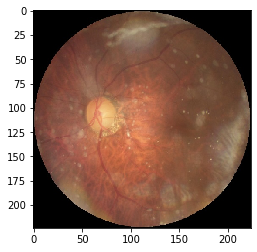

In [34]:
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()
# check img for rescaling

# Build ML model

In [41]:
# get VGG16 base model
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [42]:
# checkpoint & early stop
checkpoint = ModelCheckpoint("vgg16_glaucoma.h5",
                             monitor='accuracy',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             period=1)

early = EarlyStopping(monitor='accuracy',
                      min_delta=0,
                      patience=3,
                      verbose=1,
                      mode='auto')

In [43]:
# set constants for model training
batch_size = 32
n_spe = train_gen.samples // batch_size
n_val_steps = valid_gen.samples // batch_size
n_epochs = 30

In [44]:
# fit training data to VGG16 ML model
hist = model.fit(train_gen,
                        steps_per_epoch=n_spe,
                        validation_data=valid_gen,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        use_multiprocessing=False,
                        callbacks=[checkpoint,early])

Epoch 1/30
24/24 [==============================] - ETA: 0s - loss: 1.6724 - accuracy: 0.5409
Epoch 1: accuracy improved from -inf to 0.54090, saving model to vgg16_glaucoma.h5
24/24 [==============================] - 91s 4s/step - loss: 1.6724 - accuracy: 0.5409
Epoch 2/30
24/24 [==============================] - ETA: 0s - loss: 0.7600 - accuracy: 0.6385
Epoch 2: accuracy improved from 0.54090 to 0.63852, saving model to vgg16_glaucoma.h5
24/24 [==============================] - 92s 4s/step - loss: 0.7600 - accuracy: 0.6385
Epoch 3/30
24/24 [==============================] - ETA: 0s - loss: 0.6448 - accuracy: 0.6628
Epoch 3: accuracy improved from 0.63852 to 0.66276, saving model to vgg16_glaucoma.h5
24/24 [==============================] - 93s 4s/step - loss: 0.6448 - accuracy: 0.6628
Epoch 4/30
24/24 [==============================] - ETA: 0s - loss: 0.5905 - accuracy: 0.7005
Epoch 4: accuracy improved from 0.66276 to 0.70053, saving model to vgg16_glaucoma.h5
24/24 [===============

In [45]:
from keras.models import load_model
model = load_model('./vgg16_glaucoma.h5')

In [48]:
test_gen.reset()
pred = model.predict_generator(test_gen,verbose=1,steps=test_gen.samples/batch_size)

c:\users\ethan\desktop\development\pycharm\ocularimg_test\venv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


6/6 [==============================] - 23s 4s/step


In [49]:
model.evaluate(test_gen,use_multiprocessing=False)

7/7 [==============================] - 23s 3s/step - loss: 0.4388 - accuracy: 0.7980


[0.43880289793014526, 0.7979797720909119]

In [51]:
predicted_class_idx=np.argmax(pred,axis=1)
valid_labels = dict((value,key) for key,value in valid_gen.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]

filenames = test_gen.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': [valid_labels[key] for key in predicted_class_idx]})
prediction_df.head()

,Filename,Prediction
0,1225_right.jpg,glaucoma
1,3202_right.jpg,glaucoma
2,1439_left.jpg,glaucoma
3,1964_left.jpg,normal
4,2990_left.jpg,normal


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

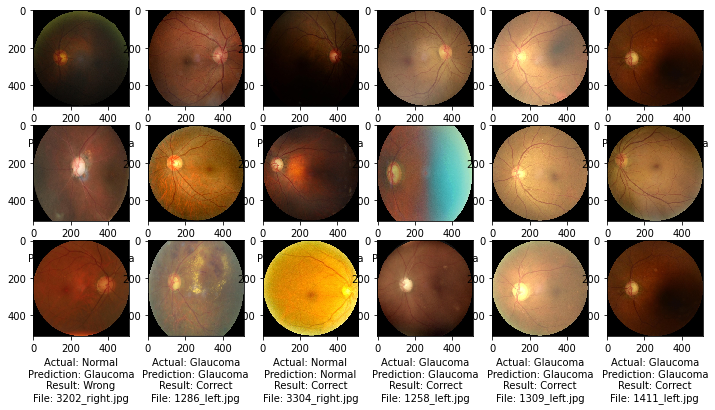

In [56]:
plt.figure(figsize=(12,6))

for i in range(18):
    # load image & category
    sample = random.choice(range(test_gen.samples))
    img = test_gen.filenames[sample]
    img_rgb = cv2.cvtColor(cv2.imread(os.path.join(img_dir, img)), cv2.COLOR_BGR2RGB)
    category = test_gen.labels[sample]
    pred_category = pred_labels[sample]
    # label category & check if right/wrong
    if category== 1:
        label = "Normal"
    else:
        label = "Glaucoma"

    if pred_category== "normal":
        pred_label = "Normal"
    else:
        pred_label = "Glaucoma"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"
    # plot img
    plt.subplot(3,6,i+1)
    plt.imshow(img_rgb, interpolation='nearest')
    plt.xlabel("Actual: {}\nPrediction: {}\nResult: {}\nFile: {}".format(label, pred_label, result, test_gen.filenames[sample]))

plt.tight_layout

# Accuracy Metrics:

In [57]:
print('Classification Report')
target_names = ['Glaucoma', 'Normal']
print(classification_report(test_gen.classes, predicted_class_idx, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    Glaucoma       0.74      0.94      0.83       102
      Normal       0.91      0.65      0.76        96

    accuracy                           0.80       198
   macro avg       0.83      0.79      0.79       198
weighted avg       0.82      0.80      0.79       198



Confusion matrix, without normalization
[[96  6]
 [34 62]]


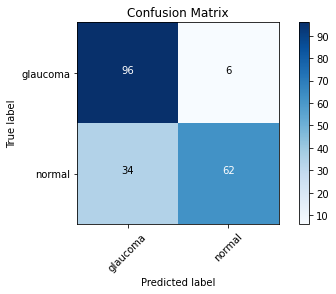

In [58]:
# confusion matrix -- func borrowed from other code
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm=confusion_matrix(test_gen.labels, predicted_class_idx), classes=['glaucoma', 'normal'], title='Confusion Matrix')

In [59]:
print(
    "Sensitivity (TPR): {}%\n"
    "Specificty (TNR): {}%".format(round(((96/(96+34))*100), 2), round(((62/(62+6))*100), 2))
)

Sensitivity (TPR): 73.85%
Specificty (TNR): 91.18%


In [60]:
print(
    "False Positive Rate (FPR): {}%\n"
    "False Negative Rate (FNR): {}%".format(round(((1-(62/(62+6)))*100), 2), round(((1-(96/(96+34)))*100), 2))
)

False Positive Rate (FPR): 8.82%
False Negative Rate (FNR): 26.15%
